In [154]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from tqdm import tqdm
from mendeleev.fetch import fetch_table
from seaborn_fig2grid import SeabornFig2Grid
import matplotlib.gridspec as gridspec


sns.set_style('whitegrid')
%matplotlib inline

sys.path.append(str(Path().resolve().parent))
Path("plots/proxy_loss").mkdir(parents=True, exist_ok=True)

In [3]:
from dave import prepare_for_gfn

In [4]:
elements = fetch_table("elements")
elements = elements.set_index("atomic_number").drop(
    [c for c in elements.columns if c not in {"symbol", "atomic_number"}], axis=1
)


def to_formula(comp_tensor):
    mask = torch.nonzero(comp_tensor)
    counts = comp_tensor[mask].numpy().ravel()
    symbols = elements.loc[mask.numpy().ravel()].symbol
    return "".join([f"{s}{c}" for s, c in zip(symbols, counts)])

In [89]:
torch.set_grad_enabled(False)

print("Loading dave model")
model, loaders, scales = prepare_for_gfn(
    release="0.3.2",
    ckpt_path_dict={"mila": "/network/scratch/s/schmidtv/crystals-proxys/proxy-ckpts/"},
    rescale_outputs=True,
    config_overrides={
        "src": "$root/data/matbench_mp_e_form",
    },
)
print("Lattice parameters are standardized with:", scales["x"])
print("Energy prediction de-normalization stats:", scales["y"])

def denorm_y(y):
    return y * scales["y"]["std"] + scales["y"]["mean"]


def denorm_x(x):
    return x * scales["x"]["std"] + scales["x"]["mean"]

Loading dave model
  Making model...

Warning, no data root specified, using default
/network/scratch/s/schmidtv/crystals-proxys/data/materials_dataset_v3

  Loading proxy checkpoint...
Proxy ready.
Lattice parameters are standardized with: {'mean': tensor([ 6.5481,  7.5332,  9.9742, 87.3101, 87.1895, 89.5657]), 'std': tensor([ 2.7462,  3.2526,  6.6441, 17.1232, 16.5463, 19.9904])}
Energy prediction de-normalization stats: {'mean': tensor(-1.4080), 'std': tensor(1.1633)}


In [90]:
(comp, sg, lps), eform_normed = next(iter(loaders["train"]))
eform = denorm_y(eform_normed)

In [91]:
df = []
for dataset in ["train", "val"]:
    for batch in tqdm(loaders[dataset], desc=dataset):
        x, eform_normed = batch
        comp, sg, lps = x
        pred_normed = model(x)
        pred = denorm_y(pred_normed)
        eform = denorm_y(eform_normed)
        lps = denorm_x(lps)

        for b in range(len(comp)):
            df.append({
                "comp": comp[b].numpy(),
                "formula": to_formula(comp[b]),
                "sg": sg[b].item(),
                "lps": lps[b].numpy(),
                "a": lps[b][0].item(),
                "b": lps[b][1].item(),
                "c": lps[b][2].item(),
                "alpha": lps[b][3].item(),
                "beta": lps[b][4].item(),
                "gamma": lps[b][5].item(),
                "eform_normed": eform_normed[b].item(),
                "eform": eform[b].item(),
                "pred_normed": pred_normed[b].item(),
                "pred": pred[b].item(),
                "dataset": dataset
            })
df = pd.DataFrame(df)
df["mae"] = df.apply(lambda row: np.abs(row["eform"] - row["pred"]), axis=1)
df["mae_normed"] = df.apply(lambda row: np.abs(row["eform_normed"] - row["pred_normed"]), axis=1)


val: 100%|██████████| 52/52 [00:09<00:00,  5.52it/s]


In [94]:
ref_df = pd.read_csv(
    "/network/scratch/s/schmidtv/crystals-proxys/data/materials_dataset_v3/data/matbench_mp_e_form/val_data.csv"
)
element_cols = list(ref_df.columns[8:102])
ref_df["formula"] = ref_df[element_cols].apply(
    lambda row: to_formula(
        torch.tensor(np.concatenate([np.array([0]), row.values.astype(int)]))
    ),
    axis=1,
)
ref_df[["formula", "a", "b", "c", "alpha", "beta", "gamma", "Eform"]].head()

,formula,a,b,c,alpha,beta,gamma,Eform
0,H24O24Al8,9.025198,5.214067,13.029678,90.0,132.66545,90.0,-2.059972
1,Si4Fe52Pr24,8.041765,8.041765,23.207384,90.0,90.00000,90.0,-0.054247
2,O4Ce1Tb1,3.864526,3.864526,5.470729,90.0,90.00000,90.0,-3.565809
3,Li8O32V12Fe4,5.903921,10.285002,9.603800,90.0,91.08280,90.0,-2.374637
4,O6In3Tl3,3.383080,3.383080,19.572418,90.0,90.00000,120.0,-1.504836


In [93]:
df[df.dataset == "val"][["formula", "a", "b", "c", "alpha", "beta", "gamma", "eform", "pred"]].head()

,formula,a,b,c,alpha,beta,gamma,eform,pred
65048,H24O24Al8,9.025198,5.214067,13.029678,90.0,132.665451,90.0,-2.059973,-2.029629
65049,Si4Fe52Pr24,8.041765,8.041765,23.207384,90.0,90.000000,90.0,-0.054247,-0.207350
65050,O4Ce1Tb1,3.864526,3.864526,5.470729,90.0,90.000000,90.0,-3.565809,-3.688746
65051,Li8O32V12Fe4,5.903921,10.285002,9.603800,90.0,91.082802,90.0,-2.374637,-2.412294
65052,O6In3Tl3,3.383080,3.383080,19.572418,90.0,90.000000,120.0,-1.504836,-1.550947


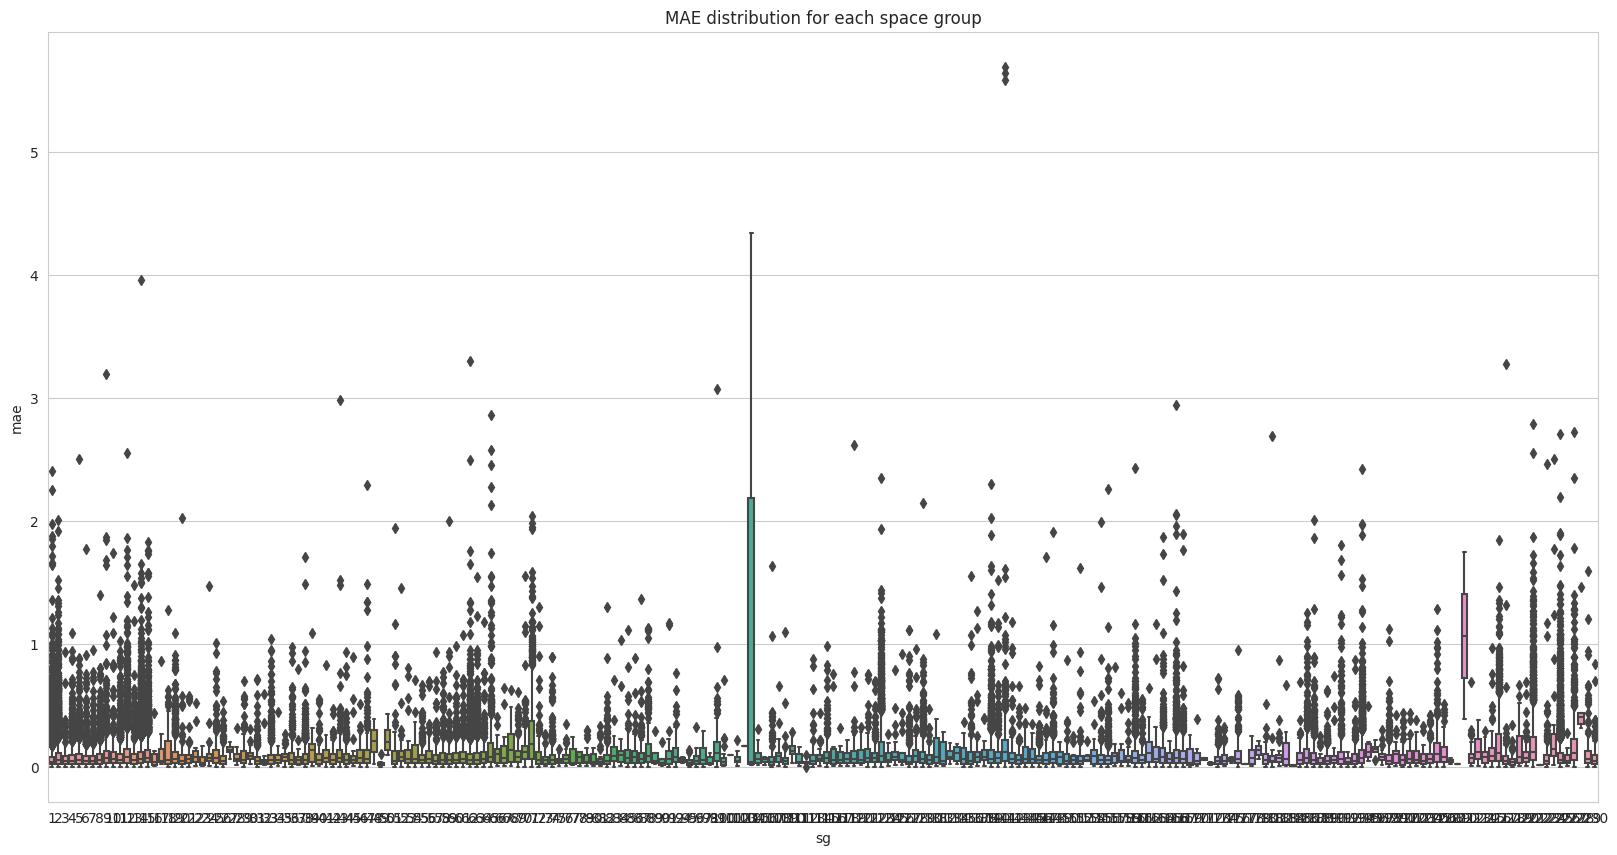

In [95]:
# boxplot of the MAE distribution for each space group
plt.figure(figsize=(20, 10))
sns.boxplot(x="sg", y="mae", data=df)
plt.title("MAE distribution for each space group")
plt.show()

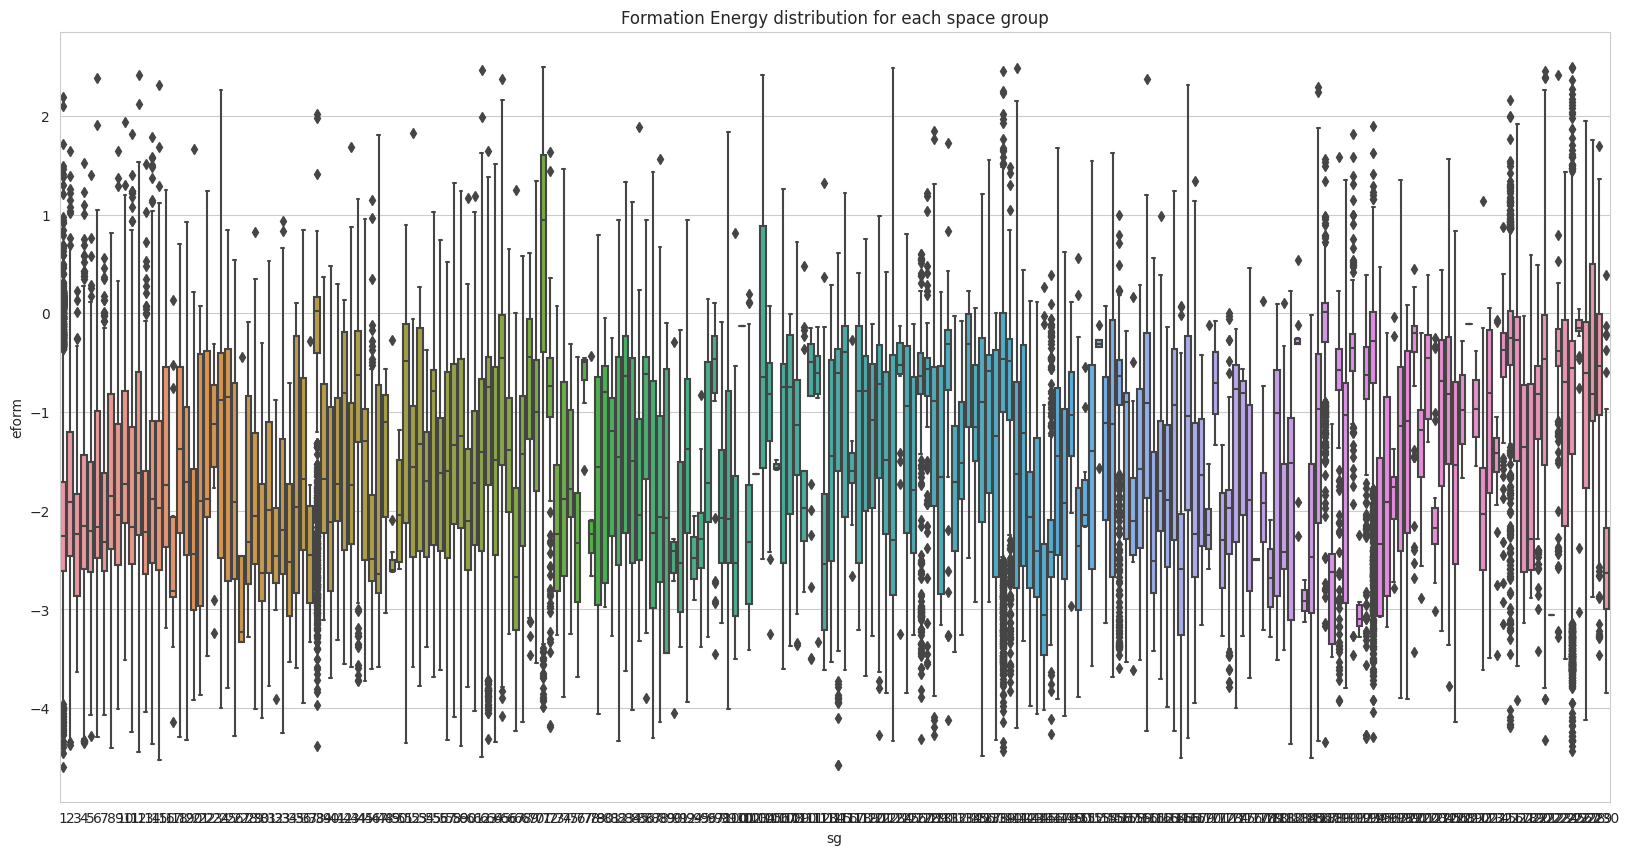

In [103]:
# boxplot of the MAE distribution for each space group
plt.figure(figsize=(20, 10))
sns.boxplot(x="sg", y="eform", data=df)
plt.title("Formation Energy distribution for each space group")
plt.show()

In [104]:
stats = df[["sg", "mae", "eform"]].groupby("sg").describe()
stats

mae                                                              \
      count      mean       std       min       25%       50%       75%   
sg                                                                        
1    6887.0  0.072297  0.122795  0.000012  0.018838  0.041733  0.080174   
2    5057.0  0.096942  0.138755  0.000057  0.025702  0.054257  0.110105   
3     153.0  0.077867  0.111975  0.001207  0.019706  0.047527  0.090146   
4    1145.0  0.083437  0.111951  0.000007  0.022969  0.048311  0.095960   
5     968.0  0.087586  0.129791  0.000129  0.024801  0.056163  0.107082   
..      ...       ...       ...       ...       ...       ...       ...   
226    34.0  0.066940  0.054343  0.003688  0.033124  0.049451  0.097016   
227   836.0  0.184585  0.245572  0.000051  0.053870  0.108668  0.226891   
228     7.0  0.534317  0.412954  0.318622  0.343628  0.403526  0.433092   
229   190.0  0.123507  0.197964  0.000104  0.030828  0.063491  0.126150   
230   250.0  0.080372  0.098876  0.000597  0.021587  0.049501  0.098687   

                eform                                                    \
          max   count      mean       std       min       25%       50%   
sg                                                                        
1    2.401274  6887.0 -2.041659  0.898310 -4.594055 -2.607966 -2.259071   
2    2.004601  5057.0 -1.808466  0.884906 -4.375688 -2.456578 -1.906877   
3    0.930048   153.0 -2.128299  0.913080 -3.630008 -2.859140 -2.231549   
4    1.090496  1145.0 -1.998061  0.927110 -4.357441 -2.586727 -2.151415   
5    2.499013   968.0 -2.026156  0.901167 -4.284491 -2.617467 -2.208754   
..        ...     ...       ...       ...       ...       ...       ...   
226  0.275561    34.0 -0.307373  0.629502 -3.022689 -0.183512 -0.147629   
227  2.723094   836.0 -0.963691  1.197423 -4.124718 -1.770366 -0.602683   
228  1.464629     7.0 -0.443058  1.535490 -2.871957 -1.088608 -0.818846   
229  1.589962   190.0 -0.778703  1.022018 -3.461780 -1.025194 -0.536541   
230  0.834541   250.0 -2.561607  0.690025 -3.850982 -2.996301 -2.628423   

                         
          75%       max  
sg                       
1   -1.709589  2.193711  
2   -1.200867  1.649880  
3   -1.826162  0.225919  
4   -1.430220  1.524675  
5   -1.508533  1.406549  
..        ...       ...  
226 -0.066644  0.042631  
227 -0.089234  1.954309  
228  0.503549  1.759512  
229 -0.003556  1.697594  
230 -2.179336  0.384625  

[226 rows x 16 columns]

Text(0.5, 1.0, 'Space Group histogram')

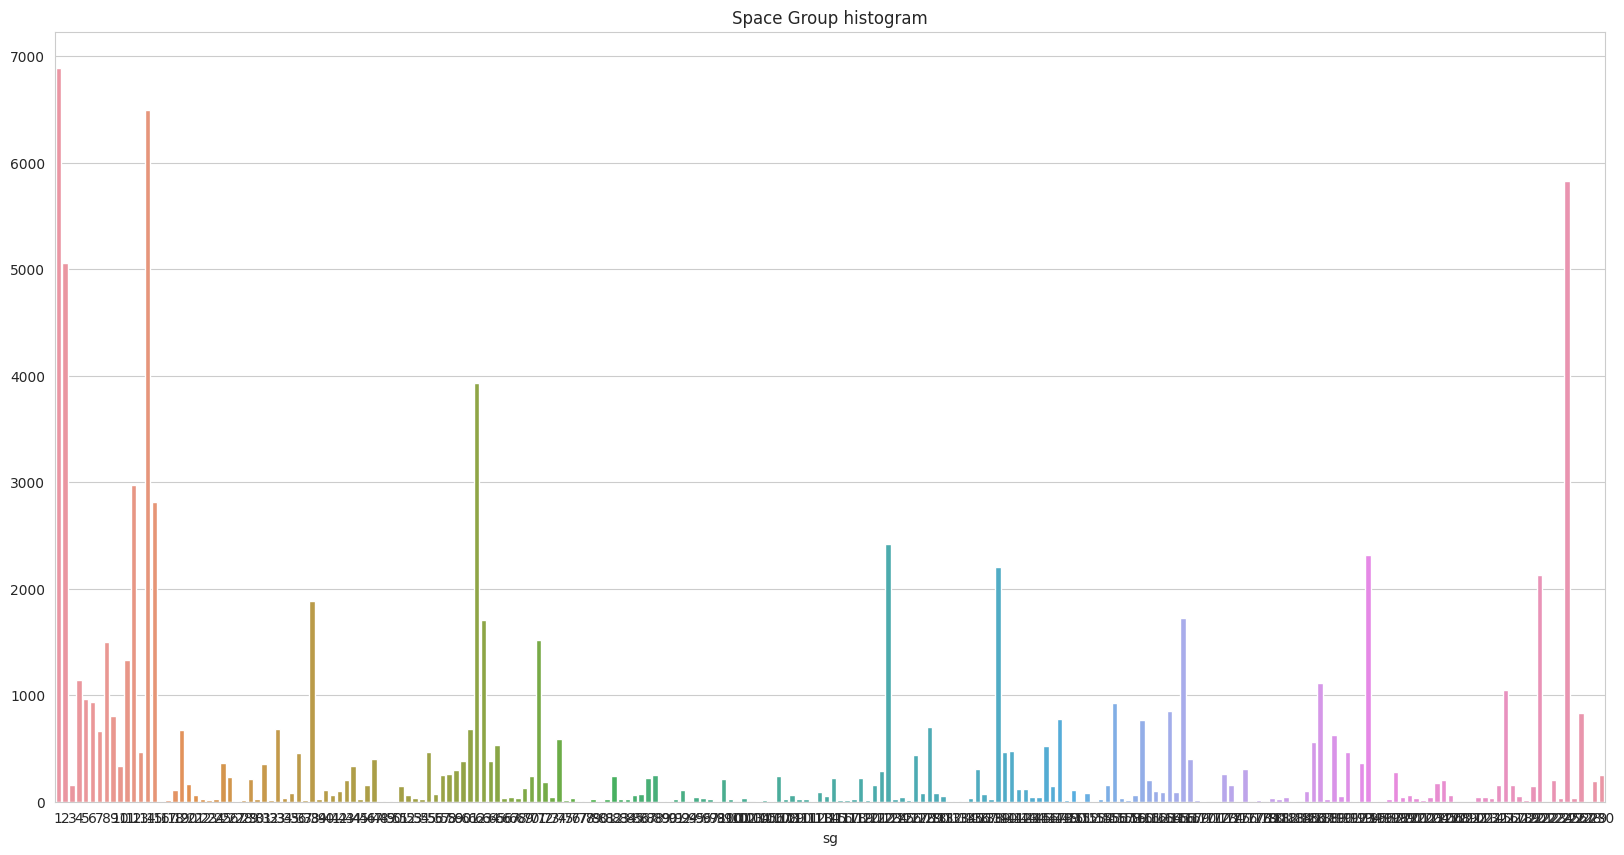

In [105]:
plt.figure(figsize=(20, 10))
sns.barplot(x=stats["mae"]["count"].index, y=stats["mae"]["count"].values)
plt.title("Space Group histogram")

In [123]:
mask = stats["eform"]["75%"] > 0
sg_pos = set(mask[mask].index)
print("Selecting space groups with Formation Energy 75% quantile > 0:", sg_pos, f"(n={mask.sum()})")

Selecting space groups with Formation Energy 75% quantile > 0: {194, 228, 38, 71, 104, 139, 216, 187} (n=8)


In [124]:
# boxplot of the MAE distribution for each space group
double_df = df.copy()
double_df["sg"] = "all"
double_df = pd.concat([df.copy(), double_df])

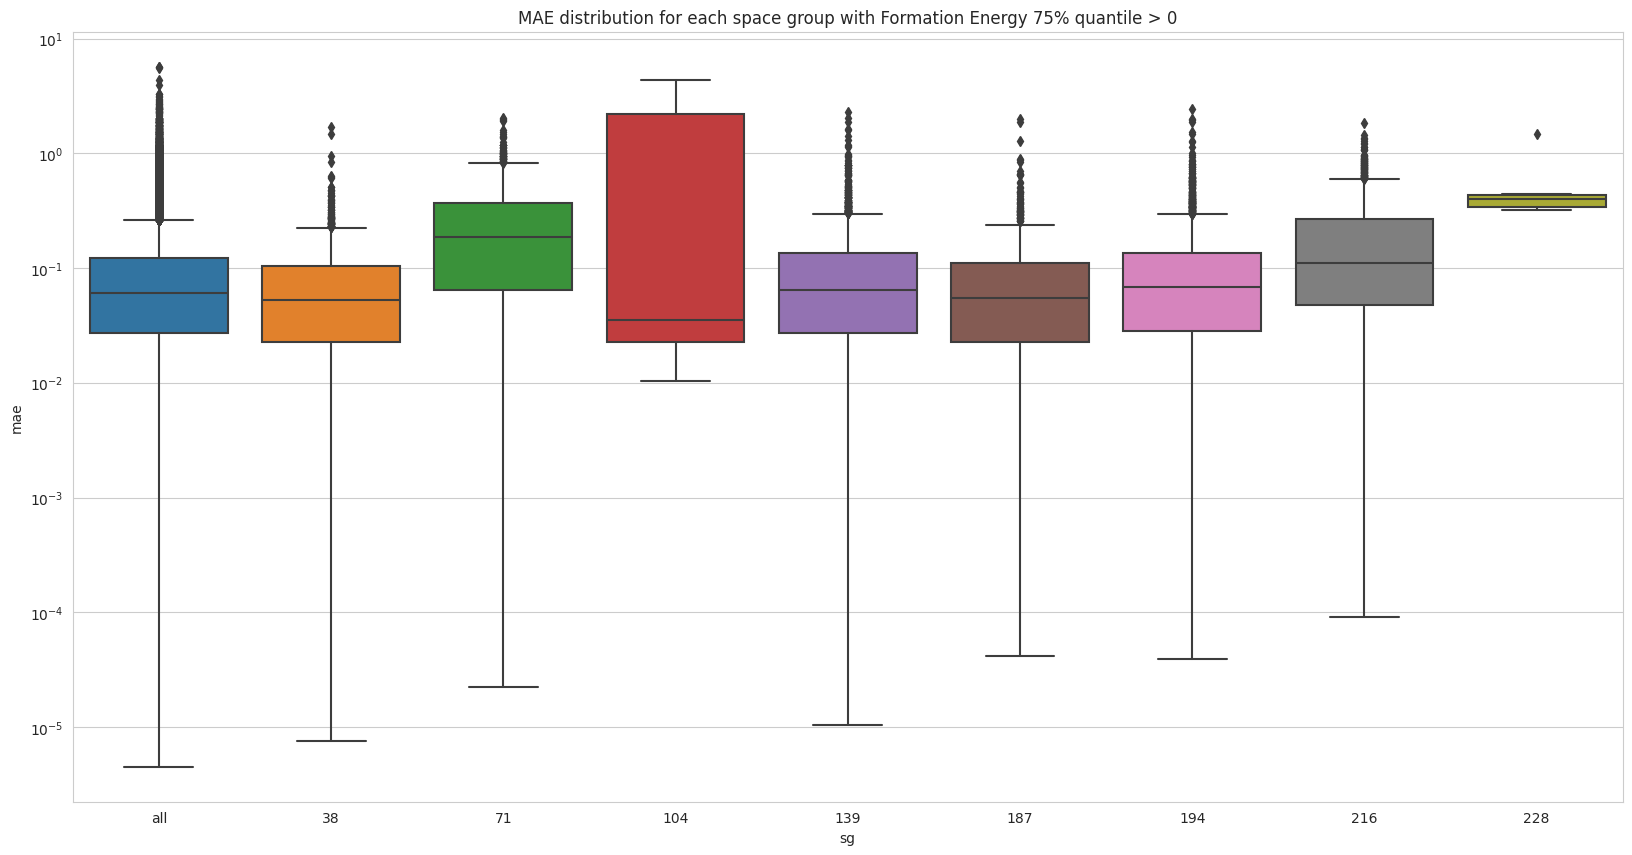

In [125]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="sg", y="mae", data=double_df[double_df["sg"].isin(sg_pos | set(["all"]))], order=["all"] + sorted(sg_pos))
plt.title("MAE distribution for each space group with Formation Energy 75% quantile > 0")
plt.yscale("log")
plt.show()

/tmp/ipykernel_50735/2128702358.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[0].set_ylim(0, 1000)
/tmp/ipykernel_50735/2128702358.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1].set_ylim(0, 1000)


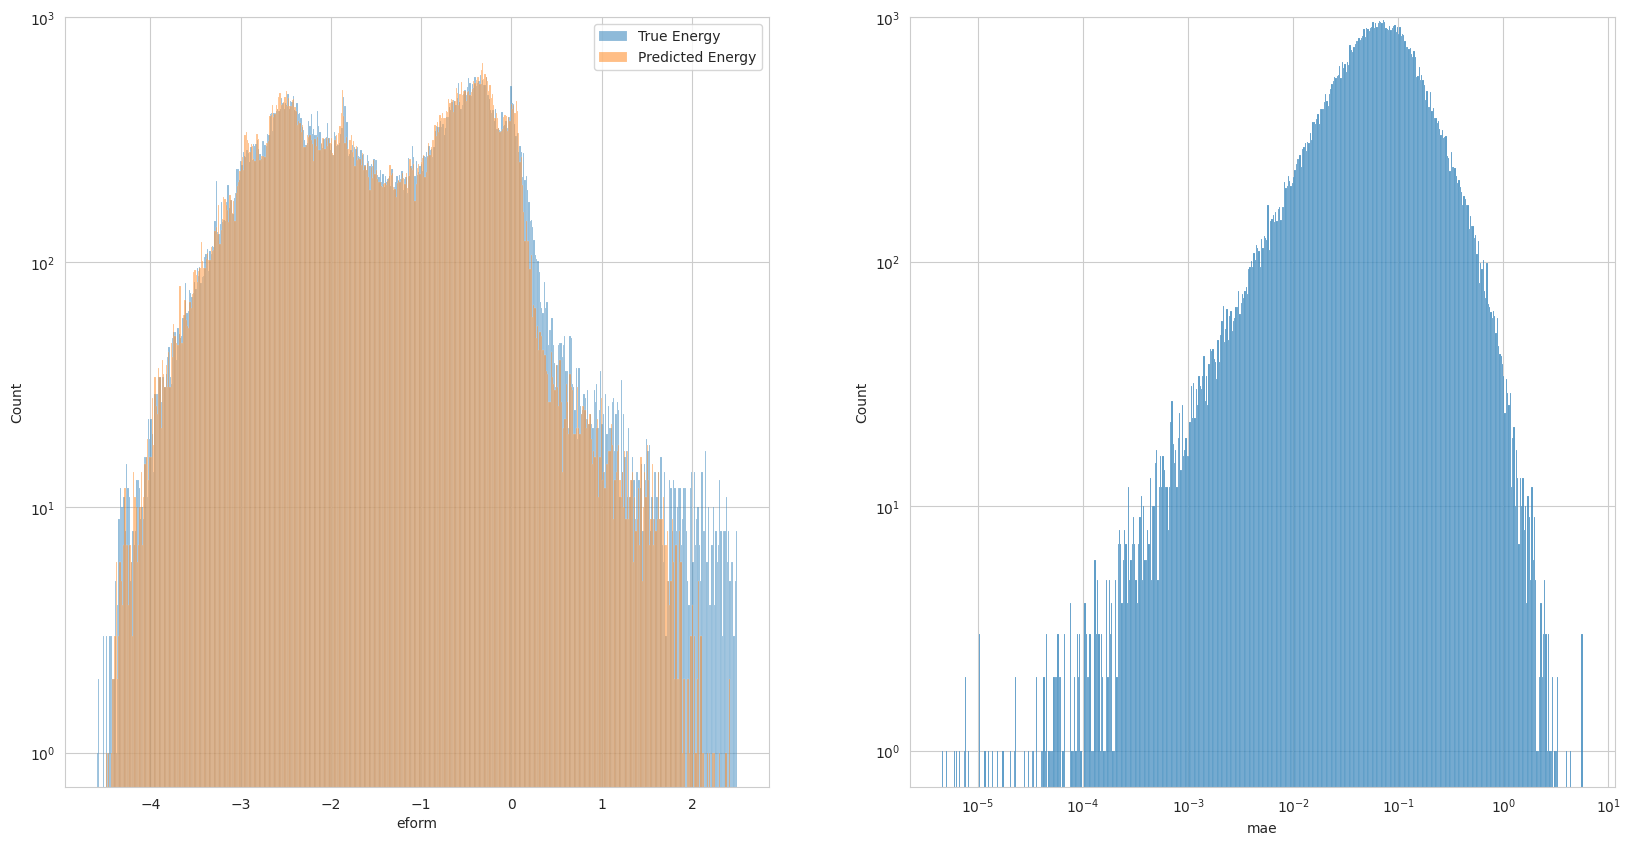

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(df["eform"], bins=500, log_scale=(False, True), ax=axs[0], label="True Energy", alpha=0.5)
sns.histplot(df["pred"], bins=500, log_scale=(False, True), ax=axs[0], label="Predicted Energy", alpha=0.5)
sns.histplot(df["mae"], label="MAE", bins=500, log_scale=(True, True), ax=axs[1])
axs[0].set_ylim(0, 1000)
axs[1].set_ylim(0, 1000)
axs[0].legend()

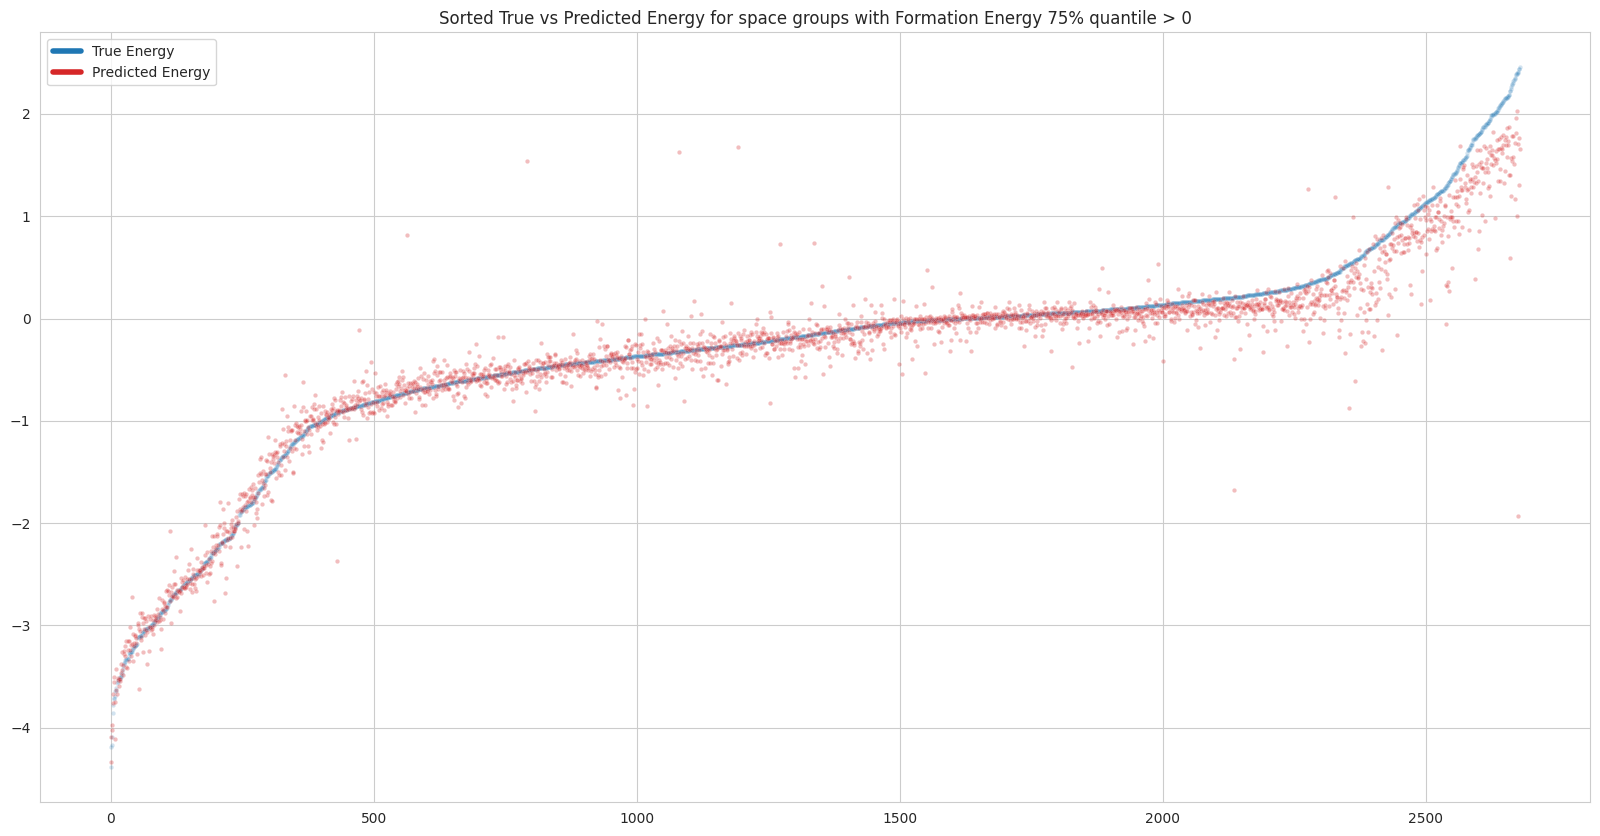

In [169]:
sorted_df = df[(df.dataset == "val") & (df.sg.isin(sg_pos))]
sort_idx = np.argsort(sorted_df["eform"].values)
plt.figure(figsize=(20, 10))
sns.scatterplot(
    x=np.arange(len(sorted_df)),
    y=sorted_df["eform"].values[sort_idx],
    label="True Energy",
    alpha=0.2,
    s=10,
)
sns.scatterplot(
    x=np.arange(len(sorted_df)),
    y=sorted_df["pred"].values[sort_idx],
    label="Predicted Energy",
    alpha=0.3,
    s=10,
    color="C3",
)
plt.title("Sorted True vs Predicted Energy for space groups with Formation Energy 75% quantile > 0")
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="C0", lw=4, label="True Energy"),
        plt.Line2D([0], [0], color="C3", lw=4, label="Predicted Energy"),
    ],
)

In [152]:
import matplotlib.gridspec as gridspec


def joint_plot(
    df,
    x,
    y,
    scale_kwarg={},
    labels={
        "mae": "MAE (eV)",
        "eform": "Formation Energy (eV)",
        "sg": "Space Group",
    },
):
    plt.figure(figsize=(10, 10))
    g = sns.JointGrid(data=df, x=x, y=y, marginal_ticks=True)
    g.ax_joint.set(**scale_kwarg)
    g.plot_joint(
        sns.histplot,
        discrete=(False, False),
        cmap="light:#03012d",
        pmax=0.8,
        bins=500,
    )
    g.plot_marginals(sns.histplot, element="step", color="#03012d")
    g.set_axis_labels(xlabel=labels[x], ylabel=labels[y])
    return g

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

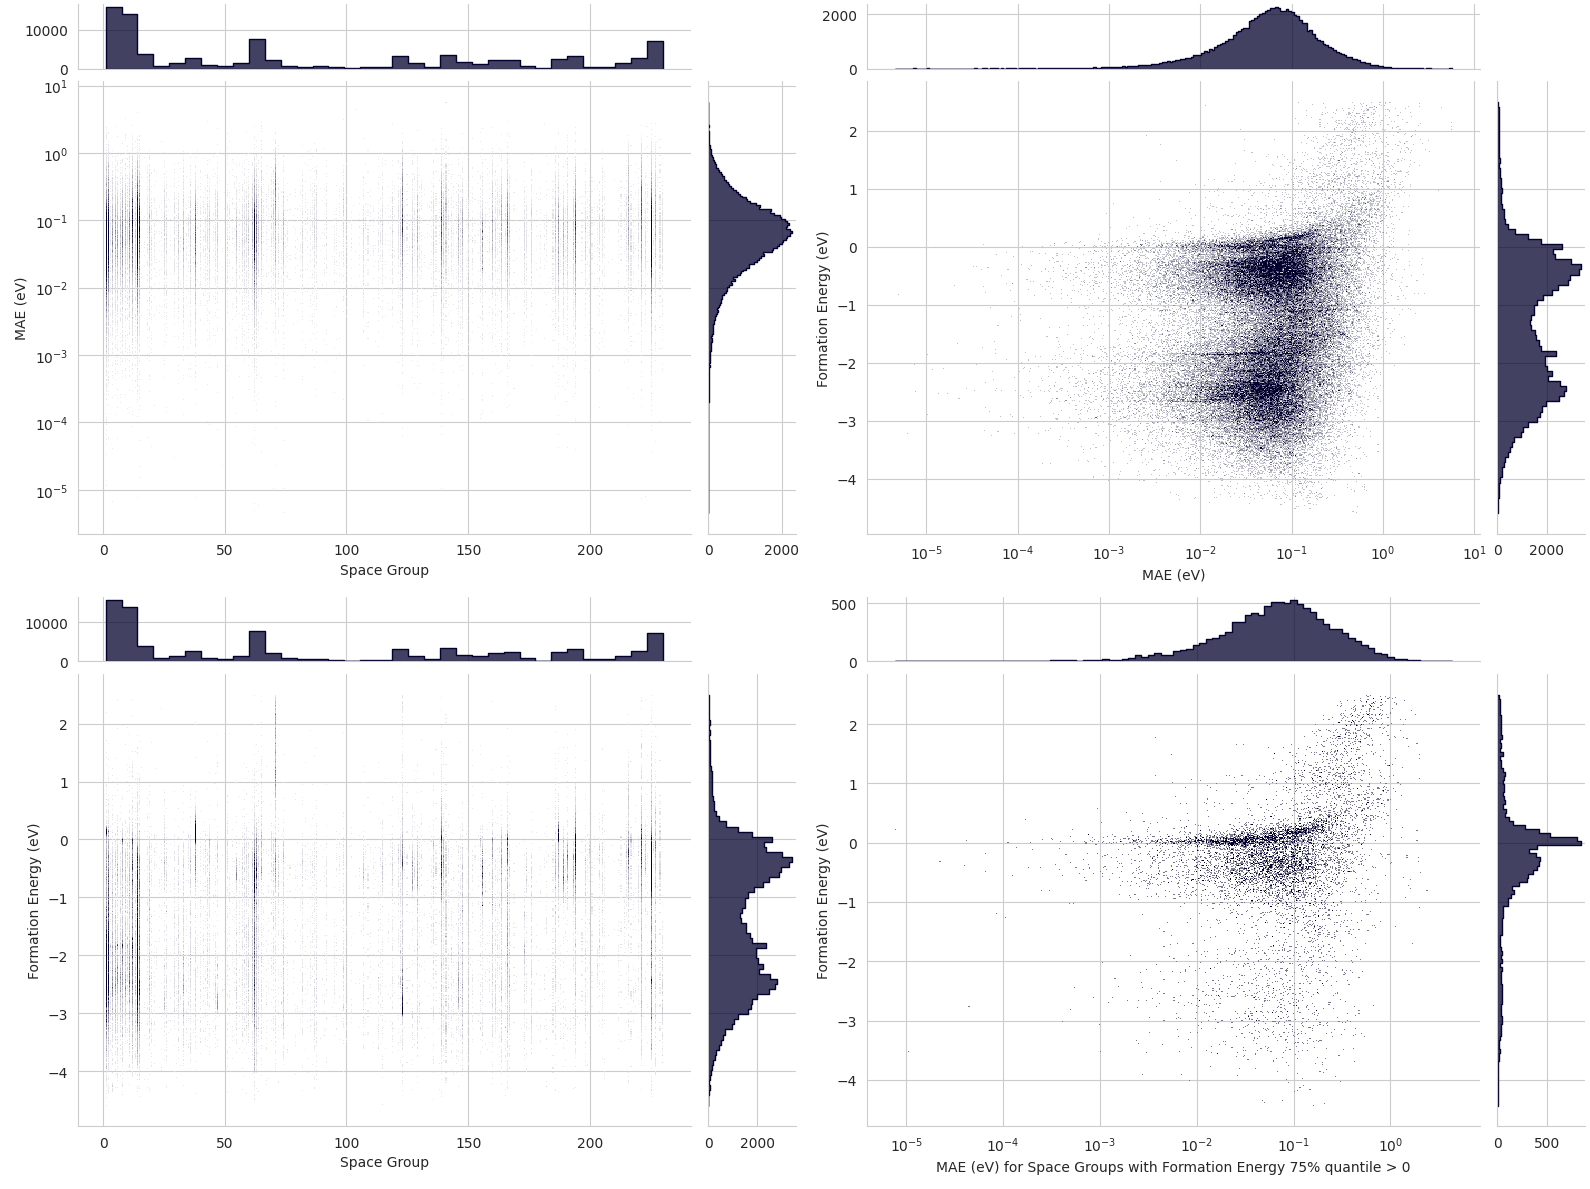

In [156]:
g0 = joint_plot(df, "sg", "mae", scale_kwarg={"yscale": "log"})
g1 = joint_plot(df, "sg", "eform")
g2 = joint_plot(df, "mae", "eform", scale_kwarg={"xscale": "log"})
g3 = joint_plot(
    df[df.sg.isin(sg_pos)],
    "mae",
    "eform",
    scale_kwarg={"xscale": "log"},
    labels={
        "mae": "MAE (eV) for Space Groups with Formation Energy 75% quantile > 0",
        "eform": "Formation Energy (eV)",
        "sg": "Space Group",
    },
)

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg2 = SeabornFig2Grid(g1, fig, gs[2])

mg1 = SeabornFig2Grid(g2, fig, gs[1])
mg3 = SeabornFig2Grid(g3, fig, gs[3])


gs.tight_layout(fig)
# gs.update(top=0.7)

plt.savefig("plots/proxy_loss/mae_eform_jointplot.png", dpi=300)
plt.show()

In [71]:
loaders["train"].dataset.root


'/home/mila/s/schmidtv/ocp-project/ActiveLearningMaterials/dave/proxies/matbench_mp_e_form'

In [83]:
model.loaded_config["src"]

'$root/dave/proxies/matbench_mp_e_form'

In [157]:
df.to_csv("plots/proxy_loss/proxy_loss.csv", index=False)

In [158]:
sorted({194, 228, 38, 71, 104, 139, 216, 187})

[38, 71, 104, 139, 187, 194, 216, 228]